## 1. 필요 라이브러러 임포트 및 다운로드

In [17]:
# -------------------------------------------
# 1. 라이브러리 설치 및 임포트
# -------------------------------------------

import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
import random
import os

# 재현성 설정
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## 데이터 로딩 함수 정의

In [18]:
# -------------------------------------------
# 2. 데이터 로딩 함수 정의
# -------------------------------------------
def load_mfcc_data(audio_path, label_path, max_len=170):
    X_list, y_list = [], []
    with open(label_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    filename = parts[1]
                    label = parts[-1]
                    fp = os.path.join(audio_path, filename)
                    if not os.path.isfile(fp):
                        continue
                    try:
                        audio, sr = librosa.load(fp, sr=16000)
                        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).T # 기존의 13차원에서 20차원으로 변경
                        if mfcc.shape[0] < max_len:
                            mfcc = np.pad(mfcc, ((0, max_len - mfcc.shape[0]), (0, 0)), mode='constant')
                        else:
                            mfcc = mfcc[:max_len]
                        X_list.append(mfcc)
                        y_list.append(0 if label == 'Real' else 1)
                    except:
                        continue

    return np.array(X_list), np.array(y_list)
from sklearn.preprocessing import StandardScaler
def standardize(X):
    ns, nt, nf = X.shape
    scaler = StandardScaler().fit(X.reshape(-1, nf))
    X_scaled = scaler.transform(X.reshape(-1, nf)).reshape(ns, nt, nf)
    return X_scaled, scaler

## DNN 모델 정의

In [6]:
def build_dnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## 학습용 데이터 로딩

In [19]:
train_audio_path = '2501ml_data/train'
train_label_path = '2501ml_data/label/train_label.txt'

### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.

In [27]:
max_len = 200
X, y = load_mfcc_data(train_audio_path, train_label_path, max_len)
X, scaler = standardize(X)

# 모델 학습

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=41
)

model = build_dnn_model(input_shape=(max_len, X.shape[2]))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8506 - loss: 0.3232 - val_accuracy: 0.9900 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0262 - val_accuracy: 0.9912 - val_loss: 0.0338 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0169 - val_accuracy: 0.9862 - val_loss: 0.0801 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0141 - val_accuracy: 0.9900 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0081 - val_accuracy: 0.9900 - val_loss: 0.0610 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0135 - val_accuracy: 0.9875 - val_loss: 0.0660 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0087 - 

## 모델 학습 과정 시각화

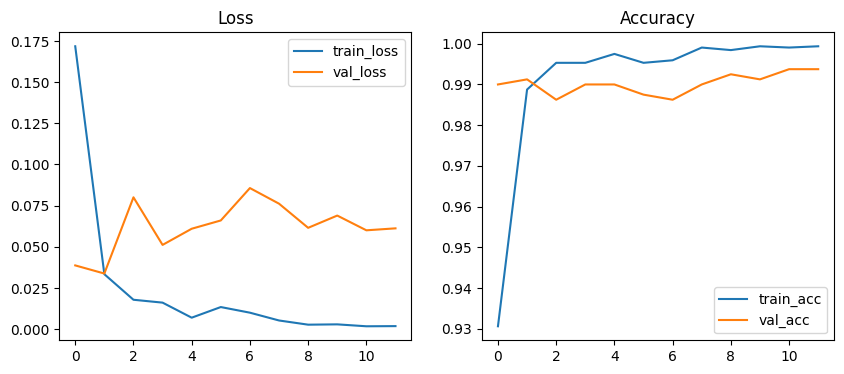

In [47]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

plot_history(history)
model.save("dnn_model.h5")